In [9]:
import sys
sys.path.append("..")
from nnterp import load_model
import torch as th
th.set_grad_enabled(False)
import gc
import pandas as pd
from tqdm import tqdm
# from utils import feature_df
import json
from dictionary_learning import CrossCoder
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from contextlib import nullcontext
twins = th.tensor(json.load(open("../data/twins.json")))
gemma_2 = load_model("google/gemma-2-2b", device_map="cuda:0")
gemma_2_it = load_model("google/gemma-2-2b-it", device_map=f"cuda:{th.cuda.device_count() - 1}")
# df = feature_df()
# crosscoder = Crosscoder.from_pretrained
crosscoder = CrossCoder.from_pretrained("Butanium/gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", from_hub=True, device="cuda")

In [10]:
results = th.load("/workspace/data/results/it_base_twins_activation_statistics_N10000000.pt")

/tmp/ipykernel_84855/4049909229.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Exploration

In [11]:
results.keys()

dict_keys(['count_joint', 'count_A', 'count_B', 'count_A_B', 'count_B_A', 'count_total', 'correAB', 'correBA'])

count_joint torch.Size([109]) tensor(3011.) tensor(82876.)
count_A torch.Size([109]) tensor(5491.) tensor(228257.)
count_B torch.Size([109]) tensor(7078.) tensor(325176.)
count_A_B torch.Size([109]) tensor(3832.) tensor(190653.)
count_B_A torch.Size([109]) tensor(5726.) tensor(283875.)
correAB torch.Size([109]) tensor(5.5110e-09, device='cuda:0') tensor(7.7471e-08, device='cuda:0')
correBA torch.Size([109]) tensor(5.5110e-09, device='cuda:0') tensor(7.7471e-08, device='cuda:0')


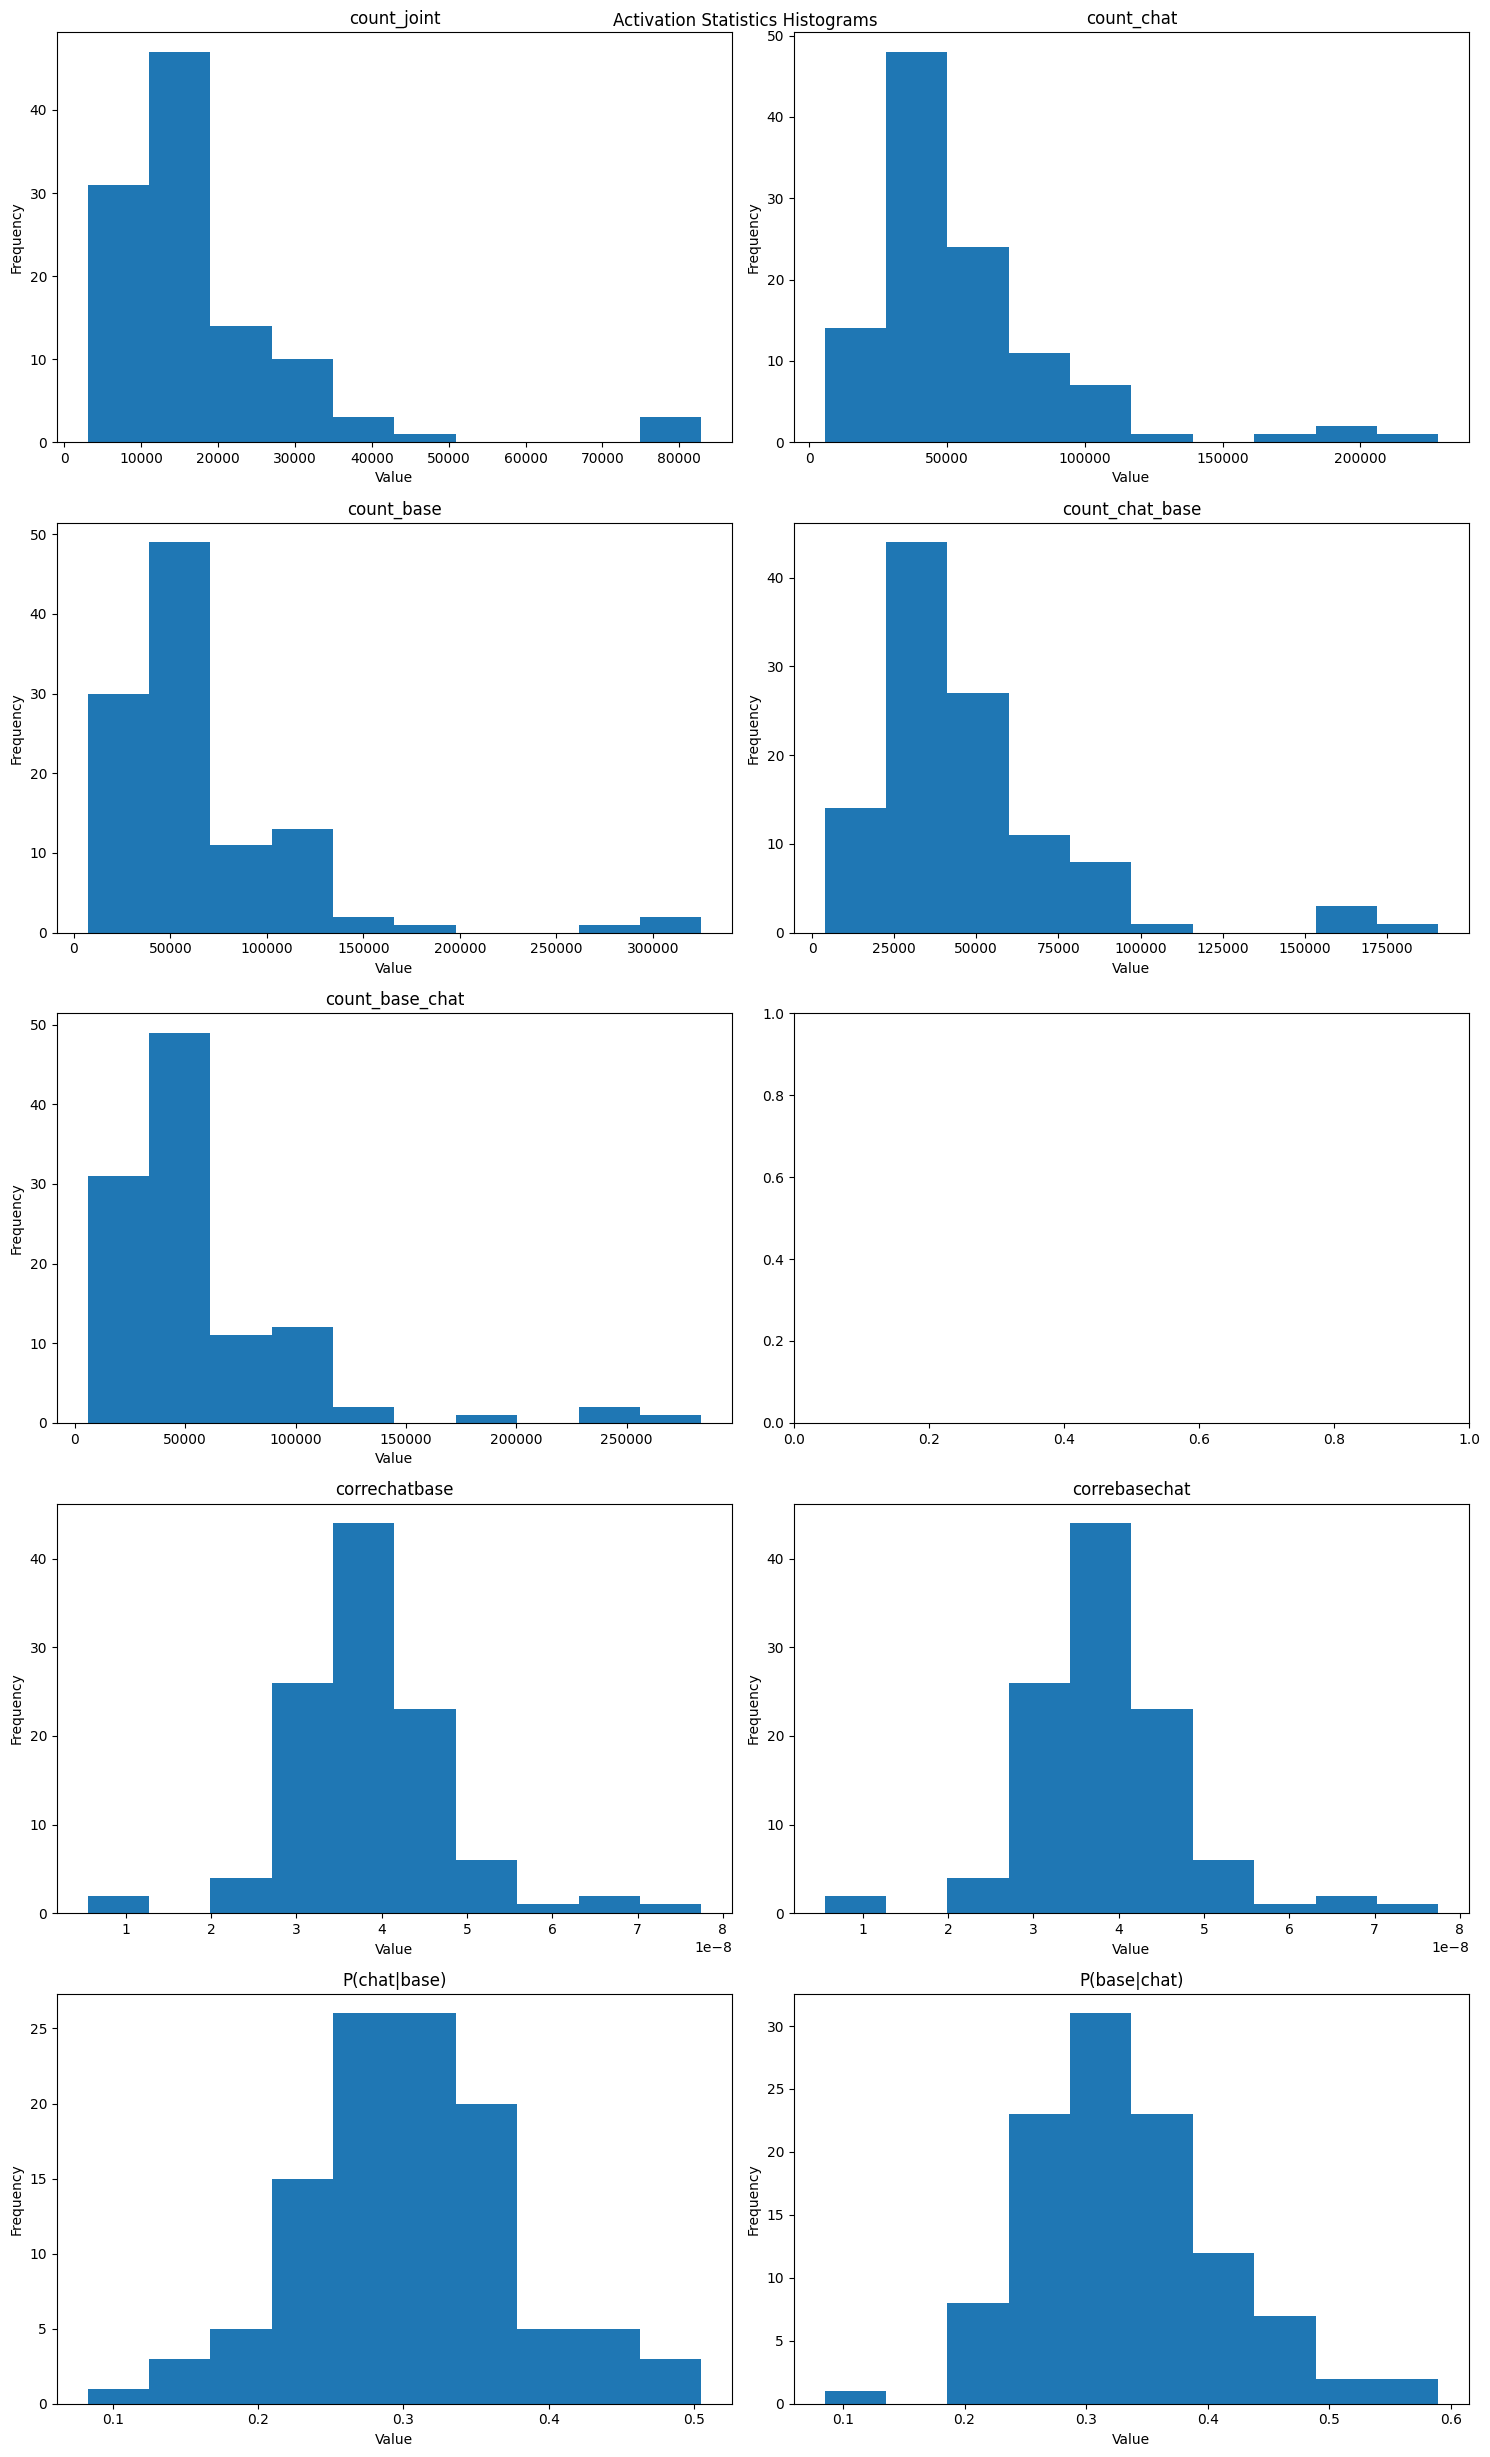

In [12]:
#results.keys() dict_keys(['count_joint', 'count_A', 'count_B', 'count_A_B', 'count_B_A', 'count_total', 'correAB', 'correBA'])

# Create a figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Activation Statistics Histograms')

# Flatten axs for easier iteration
axs = axs.flatten()

# Plot histograms for each tensor in results
for i, (key, tensor) in enumerate(results.items()):
    if key == "count_total":
        continue
    print(key, tensor.shape, tensor.min(), tensor.max())
    axs[i].hist(tensor.cpu().numpy().flatten())
    axs[i].set_title(key.replace('A', 'chat').replace('B', 'base'))
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

# Calculate and plot P(A|B) and P(B|A)
P_A_given_B = results['count_joint'] / results['count_B']
P_B_given_A = results['count_joint'] / results['count_A']

axs[8].hist(P_A_given_B.cpu().numpy().flatten())
axs[8].set_title('P(chat|base)')
axs[8].set_xlabel('Value')
axs[8].set_ylabel('Frequency')

axs[9].hist(P_B_given_A.cpu().numpy().flatten())
axs[9].set_title('P(base|chat)')
axs[9].set_xlabel('Value')
axs[9].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# show twins with min P(A|B) and print their P(B|A) and vice versa
# Find indices of min P(A|B) and P(B|A)
min_P_A_given_B_idx = th.argmin(P_A_given_B)
min_P_B_given_A_idx = th.argmin(P_B_given_A)

print("Twin pair with minimum P(A|B):")
print(f"P(A|B) = {P_A_given_B.flatten()[min_P_A_given_B_idx]:.4f}")
print(f"P(B|A) = {P_B_given_A.flatten()[min_P_A_given_B_idx]:.4f}")
print()

print("Twin pair with minimum P(B|A):")
print(f"P(A|B) = {P_A_given_B.flatten()[min_P_B_given_A_idx]:.4f}") 
print(f"P(B|A) = {P_B_given_A.flatten()[min_P_B_given_A_idx]:.4f}")


Twin pair with minimum P(A|B):
P(A|B) = 0.0823
P(B|A) = 0.0849

Twin pair with minimum P(B|A):
P(A|B) = 0.0823
P(B|A) = 0.0849


# Report

In [14]:
P_A_given_B = results['count_joint'] / results['count_B']
P_B_given_A = results['count_joint'] / results['count_A']

In [17]:
len(twins)

109

In [20]:
import sys
import torch as th
import numpy as np
from tqdm.auto import tqdm
from torch.nn.functional import cosine_similarity
from torch.nn.functional import kl_div
import warnings
from pathlib import Path

from typing import Any, Union

from torch import Tensor
from torchmetrics.aggregation import BaseAggregator


template_path = (
    "../templates/gemma_chat_template_ctrl_tokens.jinja"
)
chat_template_path = "../templates/gemma_chat_template.jinja"
with open(template_path, "r") as f:
    ctrl_template = f.read()
with open(chat_template_path, "r") as f:
    chat_template = f.read()


def feature_df():
    global df
    if df is None:
        df_path = hf_hub_download(
            repo_id="Butanium/max-activating-examples-gemma-2-2b-l13-mu4.1e-02-lr1e-04",
            filename="feature_df.csv",
            repo_type="dataset",
        )
        df = pd.read_csv(df_path, index_col=0)
    return df


def base_only_latent_indices():
    df = feature_df()
    # filter for tag = Base only
    return th.tensor(df[df["tag"] == "Base only"].index.tolist())


def it_only_latent_indices():
    df = feature_df()
    # filter for tag = IT only
    return th.tensor(df[df["tag"] == "IT only"].index.tolist())


def shared_latent_indices():
    df = feature_df()
    # filter for tag = Shared
    return th.tensor(df[df["tag"] == "Shared"].index.tolist())


class CCLatent:
    def __init__(self, id_: int):
        self.id = id_
        self.tag = df.loc[id_, "tag"]

    def stats(self):
        return feature_df().loc[self.id]


"""
=================================
=                               =
=         Plotting utils        =
=                               =
=================================
"""
from tiny_dashboard.html_utils import (
    create_token_html,
    create_example_html,
    create_base_html,
)
from tiny_dashboard.utils import sanitize_tokens, sanitize_token
import networkx as nx
from networkx.drawing.nx_pylab import apply_alpha
from huggingface_hub import hf_hub_download
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


def activation_visualization(
    tokens: list[str],
    activations: th.Tensor,
    tokenizer,
    highlight_idx: int | None = None,
    title: str = "",
) -> str:
    """Create HTML with highlighted tokens based on activation values"""
    html_parts = []
    # all_feature_indicies = list(range(activations.shape[0]))
    # Find highlight feature index in the activation tensor
    if highlight_idx is None:
        if activations.dim() == 2:
            raise ValueError(
                "Activations must be 1D unless a highlight feature is specified"
            )
        highlight_acts = activations
        activations = activations.unsqueeze(0)
        other_features = [0]
    else:
        highlight_acts = activations[highlight_idx]
        other_features = [i for i in range(activations.shape[0]) if i != highlight_idx]
    # Normalize activations for color intensity (only for highlight feature)
    max_highlight = highlight_acts.max()
    norm_acts = highlight_acts / (max_highlight + 1e-6)

    # Create HTML spans with activation values
    sanitized_tokens = sanitize_tokens(tokens, non_breaking_space=False)
    for i, (san_token, token) in enumerate(zip(sanitized_tokens, tokens)):

        color = f"rgba(255, 0, 0, {norm_acts[i].item():.3f})"

        # Create tooltip content only for requested features
        tok_id = tokenizer.convert_tokens_to_ids(token)
        tooltip_token = sanitize_token(
            token, keep_newline=False, non_breaking_space=False
        )
        tooltip_lines = [f"Token {tok_id}: '{tooltip_token}'"]
        for feat in other_features:
            act_value = activations[feat, i].item()
            tooltip_lines.append(f"Feature {feat}: {act_value:.3f}")

        tooltip_content = "\n".join(tooltip_lines)
        html_parts.append(create_token_html(san_token, color, tooltip_content))

    html = "".join(html_parts)
    html = create_example_html(max_highlight.item(), html, static=True)
    return create_base_html(title, html)


def draw_networkx_nodes(
    G,
    pos,
    nodelist=None,
    node_size=300,
    node_color="#1f78b4",
    node_shape="o",
    alpha=None,
    cmap=None,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=None,
    edgecolors=None,
    label=None,
    margins=None,
    hide_ticks=True,
):
    """Draw the nodes of the graph G.

    This draws only the nodes of the graph G.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    nodelist : list (default list(G))
        Draw only specified nodes

    node_size : scalar or array (default=300)
        Size of nodes.  If an array it must be the same length as nodelist.

    node_color : color or array of colors (default='#1f78b4')
        Node color. Can be a single color or a sequence of colors with the same
        length as nodelist. Color can be string or rgb (or rgba) tuple of
        floats from 0-1. If numeric values are specified they will be
        mapped to colors using the cmap and vmin,vmax parameters. See
        matplotlib.scatter for more details.

    node_shape :  string (default='o')
        The shape of the node.  Specification is as matplotlib.scatter
        marker, one of 'so^>v<dph8'.

    alpha : float or array of floats (default=None)
        The node transparency.  This can be a single alpha value,
        in which case it will be applied to all the nodes of color. Otherwise,
        if it is an array, the elements of alpha will be applied to the colors
        in order (cycling through alpha multiple times if necessary).

    cmap : Matplotlib colormap (default=None)
        Colormap for mapping intensities of nodes

    vmin,vmax : floats or None (default=None)
        Minimum and maximum for node colormap scaling

    linewidths : [None | scalar | sequence] (default=1.0)
        Line width of symbol border

    edgecolors : [None | scalar | sequence] (default = node_color)
        Colors of node borders. Can be a single color or a sequence of colors with the
        same length as nodelist. Color can be string or rgb (or rgba) tuple of floats
        from 0-1. If numeric values are specified they will be mapped to colors
        using the cmap and vmin,vmax parameters. See `~matplotlib.pyplot.scatter` for more details.

    label : [None | string]
        Label for legend

    margins : float or 2-tuple, optional
        Sets the padding for axis autoscaling. Increase margin to prevent
        clipping for nodes that are near the edges of an image. Values should
        be in the range ``[0, 1]``. See :meth:`matplotlib.axes.Axes.margins`
        for details. The default is `None`, which uses the Matplotlib default.

    hide_ticks : bool, optional
        Hide ticks of axes. When `True` (the default), ticks and ticklabels
        are removed from the axes. To set ticks and tick labels to the pyplot default,
        use ``hide_ticks=False``.

    Returns
    -------
    matplotlib.collections.PathCollection
        `PathCollection` of the nodes.

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_edges
    draw_networkx_labels
    draw_networkx_edge_labels
    """
    from collections.abc import Iterable

    import matplotlib as mpl
    import matplotlib.collections  # call as mpl.collections
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()

    if nodelist is None:
        nodelist = list(G)

    if len(nodelist) == 0:  # empty nodelist, no drawing
        return mpl.collections.PathCollection(None)

    try:
        xy = np.asarray([pos[v] for v in nodelist])
    except KeyError as err:
        raise nx.NetworkXError(f"Node {err} has no position.") from err

    if isinstance(alpha, Iterable):
        node_color = apply_alpha(node_color, alpha, nodelist, cmap, vmin, vmax)
        alpha = None

    # Convert node_shape to array if it's not already
    if not isinstance(node_shape, (np.ndarray, list)):
        node_shape = [node_shape] * len(nodelist)
    node_shape = np.asarray(node_shape)

    # Convert node_color to array if it's not already
    if not isinstance(node_color, (np.ndarray, list)):
        node_color = [node_color] * len(nodelist)
    node_color = np.asarray(node_color)

    # Create collections for each unique shape-color combination
    collections = []

    for shape in np.unique(node_shape):
        shape_mask = node_shape == shape
        shape_xy = xy[shape_mask]
        shape_colors = node_color[shape_mask]

        node_collection = ax.scatter(
            shape_xy[:, 0],
            shape_xy[:, 1],
            s=node_size,
            c=shape_colors,
            marker=shape,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            alpha=alpha,
            linewidths=linewidths,
            edgecolors=edgecolors,
            label=label,
        )
        collections.append(node_collection)

    if hide_ticks:
        ax.tick_params(
            axis="both",
            which="both",
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

    if margins is not None:
        if isinstance(margins, Iterable):
            ax.margins(*margins)
        else:
            ax.margins(margins)

    # Set zorder for all collections
    for collection in collections:
        collection.set_zorder(2)

    # Return the last collection for compatibility
    return collections[-1] if collections else None


def plot_component_sizes(G, title=None):
    # bar plot of the size of the connected components
    component_sizes = [len(c) for c in nx.connected_components(G)]
    print(f"found {len(component_sizes)} connected components")
    # Count frequency of each size
    from collections import Counter

    size_counts = Counter(component_sizes)
    # Convert to lists for plotting and sort
    sizes = sorted(list(size_counts.keys()))
    counts = [size_counts[size] for size in sizes]
    fig = px.bar(
        x=sizes,
        y=counts,
        title="Distribution of connected component sizes" if title is None else title,
        labels={"x": "Component size", "y": "Number of components"},
    )
    # Only show x-axis ticks for values that exist in the data
    fig.update_xaxes(tickmode="array", tickvals=sizes, type="category")
    fig.show()
    # bar plot where x is the component size and y is the number of nodes in those components
    y = [size_counts[size] * size for size in sizes]
    fig = px.bar(
        x=sizes,
        y=y,
        title=(
            "Distribution of latent in different component sizes" + "\n"
            if title is None
            else title
        ),
        labels={"x": "Component size", "y": "Number of latents"},
    )
    # Only show x-axis ticks for values that exist in the data
    fig.update_xaxes(tickmode="array", tickvals=sizes, type="category")
    fig.show()


def draw_graph(G, title=""):
    plt.figure(figsize=(15, 5))
    pos = nx.spring_layout(G, k=0.035)  # reduced k from default

    # Create node color list and prepare for legend
    node_colors = []
    node_shapes = []
    it_only_nodes = []
    base_only_nodes = []
    shared_nodes = []
    unknown_nodes = []
    df = feature_df()
    for node in G.nodes():

        tag = df.loc[int(node[1:]), "tag"]
        if tag == "IT only":
            node_colors.append("red")
            it_only_nodes.append(node)
        elif tag == "Base only":
            node_colors.append("blue")
            base_only_nodes.append(node)
        elif tag == "Shared":
            node_colors.append("green")
            shared_nodes.append(node)
        else:
            node_colors.append("gray")
            unknown_nodes.append(node)
        if node[0] == "i":
            if tag == "Base only":
                raise Exception(f"Base only node: {node}")
            node_shapes.append("*")
        else:
            node_shapes.append("o")
        if df.loc[int(node[1:]), "dead"]:
            raise Exception(f"dead node: {node}")
    # Draw nodes with colors
    draw_networkx_nodes(
        G, pos, node_size=15, node_color=np.array(node_colors), node_shape=node_shapes
    )

    # Draw edges with width proportional to weight
    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w * 1 for w in edge_weights], alpha=0.3)

    # Add legend
    plt.scatter([], [], c="red", label="Chat only", s=20)
    plt.scatter([], [], c="blue", label="Base only", s=20)
    plt.scatter([], [], c="green", label="Shared", s=20)
    plt.scatter([], [], c="gray", label="Other", s=20)
    plt.scatter([], [], c="black", marker="*", label="Chat latents", s=20)
    plt.scatter([], [], c="black", marker="o", label="Base latents", s=20)
    plt.legend()

    plt.title(title)
    plt.axis("off")
    plt.show()


def draw_interactive_graph(G, title=""):
    df = feature_df()
    pos = nx.spring_layout(G, k=0.035)  # reduced k from default

    # Create node color list and prepare for legend
    it_only_nodes = []
    base_only_nodes = []
    shared_nodes = []
    unknown_nodes = []

    # Create lists for node traces
    node_x = []
    node_y = []
    node_colors = []
    node_symbols = []
    node_texts = []  # Added for hover text
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_texts.append(node)  # Add node name for hover

        type = df.loc[int(node[1:]), "tag"]
        if type == "IT only":
            node_colors.append("red")
            it_only_nodes.append(node)
        elif type == "Base only":
            node_colors.append("blue")
            base_only_nodes.append(node)
        elif type == "Shared":
            node_colors.append("green")
            shared_nodes.append(node)
        else:
            node_colors.append("gray")
            unknown_nodes.append(node)

        if node[0] == "i":
            node_symbols.append("star")
        else:
            node_symbols.append("circle")

        if df.loc[int(node[1:]), "dead"]:
            raise Exception(f"dead node: {node}")

    # Create edge traces
    edge_x = []
    edge_y = []
    edge_weights = []

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G[edge[0]][edge[1]]["weight"])

    # Create edge trace
    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=1, color="black"),
        hoverinfo="none",
        mode="lines",
        opacity=0.6,
        showlegend=False,
    )

    # Create node trace
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        text=node_texts,  # Add hover text
        hoverinfo="text",  # Show the text on hover
        marker=dict(size=15, color=node_colors, symbol=node_symbols),
        showlegend=False,
    )

    # Create figure
    fig = go.Figure(data=[node_trace, edge_trace])

    # Update layout
    fig.update_layout(
        title=title,
        showlegend=True,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )

    # Add legend using shapes
    legend_items = [
        ("Chat only", "red", "circle"),
        ("Base only", "blue", "circle"),
        ("Shared", "green", "circle"),
        ("Other", "gray", "circle"),
        ("Chat latents", "black", "star"),
        ("Base latents", "black", "circle"),
    ]

    for i, (name, color, symbol) in enumerate(legend_items):
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode="markers",
                name=name,
                marker=dict(size=10, color=color, symbol=symbol),
                showlegend=True,
            )
        )

    fig.show()
    return fig
df = feature_df()
df.iloc[[49685, 37320]]

NameError: name '__file__' is not defined

In [15]:
with nullcontext():
    
    # Create dataframe with P(A|B) and P(B|A) values
    df = pd.DataFrame(
        {
            "P(chat|base)": P_A_given_B.cpu().numpy().flatten(),
            "P(base|chat)": P_B_given_A.cpu().numpy().flatten(),
            "Pair": twins.tolist(),
        }
    )
    # add histogram of P(chat|base) and P(base|chat) in  a new figure
    # Create subplots with 2 columns
    fig = make_subplots(rows=1, cols=2)

    # Add histogram for P(chat|base)
    fig.add_trace(
        go.Histogram(x=df["P(chat|base)"], name="P(chat|base)"),
        row=1, col=1
    )

    # Add histogram for P(base|chat) 
    fig.add_trace(
        go.Histogram(x=df["P(base|chat)"], name="P(base|chat)"),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Histograms of Conditional Probabilities",
        showlegend=False,
        height=400,
        width=800
    )

    # Update x-axis labels
    fig.update_xaxes(title_text="P(chat|base)", row=1, col=1)
    fig.update_xaxes(title_text="P(base|chat)", row=1, col=2)

    fig.show()


    # Create scatter plot
    fig = px.scatter(
        df,
        x="P(chat|base)",
        y="P(base|chat)", 
        hover_data=["Pair"],
        title="P(chat|base) vs P(base|chat) for Each Latent Pair",
    )
    # add a line at y = x
    fig.add_trace(
        go.Scatter(
            x=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()), max(df["P(chat|base)"].max(), df["P(base|chat)"].max())],
            y=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()), max(df["P(chat|base)"].max(), df["P(base|chat)"].max())],
            mode="lines",
            line=dict(color="red", dash="dash"),
            name="y=x",
        )
    )
    # add linear regression line
    # Calculate linear regression
    slope, intercept = np.polyfit(df["P(chat|base)"], df["P(base|chat)"], 1)
    fig.add_trace(
        go.Scatter(
            x=df["P(chat|base)"],
            y=slope * df["P(chat|base)"] + intercept,
            mode="lines",
            name=f"Linear fit (slope={slope:.2f})",
        )
    )
    fig.update_layout(
        xaxis_range=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()) - 0.01, max(df["P(chat|base)"].max(), df["P(base|chat)"].max()) + 0.01],
        yaxis_range=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()) - 0.01, max(df["P(chat|base)"].max(), df["P(base|chat)"].max()) + 0.01],
    )

    fig.show()

In [16]:
results_baseline = th.load("/workspace/data/results/twins_baseline_activation_statistics_N10000000.pt")
twins_baseline = th.tensor(json.load(open("../data/twins_baseline.json")))
P_A_given_B_baseline = results_baseline['count_joint'] / results_baseline['count_B']
P_B_given_A_baseline = results_baseline['count_joint'] / results_baseline['count_A']
with nullcontext():
        # Create dataframe with P(A|B) and P(B|A) values
    df = pd.DataFrame(
        {
            "P(chat|base)": P_A_given_B_baseline.cpu().numpy().flatten(),
            "P(base|chat)": P_B_given_A_baseline.cpu().numpy().flatten(),
            "Pair": twins_baseline.tolist(),
        }
    )

    # add histogram of P(chat|base) and P(base|chat) in  a new figure
    # Create subplots with 2 columns
    fig = make_subplots(rows=1, cols=2)

    # Add histogram for P(chat|base)
    fig.add_trace(
        go.Histogram(x=df["P(chat|base)"], name="P(chat|base)"),
        row=1, col=1
    )

    # Add histogram for P(base|chat) 
    fig.add_trace(
        go.Histogram(x=df["P(base|chat)"], name="P(base|chat)"),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Histograms of Conditional Probabilities",
        showlegend=False,
        height=400,
        width=800
    )

    # Update x-axis labels
    fig.update_xaxes(title_text="P(chat|base)", row=1, col=1)
    fig.update_xaxes(title_text="P(base|chat)", row=1, col=2)

    fig.show()


    # Create scatter plot
    fig = px.scatter(
        df,
        x="P(chat|base)",
        y="P(base|chat)", 
        hover_data=["Pair"],
        title="P(chat|base) vs P(base|chat) for Each Latent Pair",
    )
    # add a line at y = x
    fig.add_trace(
        go.Scatter(
            x=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()), max(df["P(chat|base)"].max(), df["P(base|chat)"].max())],
            y=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()), max(df["P(chat|base)"].max(), df["P(base|chat)"].max())],
            mode="lines",
            line=dict(color="red", dash="dash"),
            name="y=x",
        )
    )
    # add linear regression line
    # Calculate linear regression
    slope, intercept = np.polyfit(df["P(chat|base)"], df["P(base|chat)"], 1)
    fig.add_trace(
        go.Scatter(
            x=df["P(chat|base)"],
            y=slope * df["P(chat|base)"] + intercept,
            mode="lines",
            name=f"Linear fit (slope={slope:.2f})",
        )
    )
    fig.update_layout(
        xaxis_range=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()) - 0.01, max(df["P(chat|base)"].max(), df["P(base|chat)"].max()) + 0.01],
        yaxis_range=[min(df["P(chat|base)"].min(), df["P(base|chat)"].min()) - 0.01, max(df["P(chat|base)"].max(), df["P(base|chat)"].max()) + 0.01],
    )

    fig.show()

/tmp/ipykernel_84855/3620888565.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

